# Segmentation models testing pipeline
- define train/validation/test folders
- make DataLoader for train/validation/test Datasets
- define a model
- train the model
- test the model

In [1]:
# Custum modules
from modules.datasetISIC import DatasetISIC
from modules.transformers import *

In [2]:
'''
Define train/validation/test folders
'''
train_folder = 'data/train'
validation_folder = 'data/validation'
test_folder = 'data/test'

In [4]:
'''
Define dataloader
'''
from torch.utils.data import DataLoader 
from torchvision.transforms import Compose #Resize, ToTensor

loader_parameters = {
    'batch_size': 1,
    'shuffle': True,
    'num_workers': 1,
    'drop_last': True
}

transforms = Compose([
    Resize((32,32)),
    ToTensor()
])

def make_loader(foldername, loader_parameters, transforms):
    dataset = DatasetISIC(foldername, transforms)
    return DataLoader(dataset, **loader_parameters)

train_loader = make_loader(train_folder, loader_parameters, transforms)
validation_loader = make_loader(validation_folder, loader_parameters, transforms)
test_loader = make_loader(test_folder, loader_parameters, transforms)

In [5]:
import torch
def get_segmentation_model():
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                           in_channels=3, out_channels=1, init_features=32, pretrained=True)
    return model

model = get_segmentation_model()

Using cache found in /home/ivan/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [6]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x,y):
        # set model to train mode
        model.train()
        # make predictions
        yhat = model(x)
        #compute loss
        y = y.to(device, dtype=torch.float32)
        loss = loss_fn(yhat, y)
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step

def make_val_step(model, loss_fn):
    def val_step(x,y):
        # set model to evaluation mode
        model.eval()
        # make prediction
        yhat = model(x)
        # compute loss
        val_loss = loss_fn(yhat, y)
        return val_loss.item()
    return val_step

def train(model, train_loader, n_epochs, optimizer, loss_fn, device, val_loader=None):
    model.to(device)
    
    train_step = make_train_step(model, loss_fn, optimizer)
    val_step = make_val_step(model, loss_fn)
    
    history = {'loss': [], 'val_loss': []}
    
    total_steps = len(train_loader)
    for epoch in range(n_epochs):
        for i, sample in enumerate(train_loader):
            image, mask = sample['image'].to(device), sample['mask'].to(device)
            
            loss = train_step(image, mask)
            
            history['loss'] += [loss]
            if (i+1)%500==0: print('Epoch[{}/{}][{}/{}] loss: {}'
                                  .format(epoch+1, n_epochs,i+1,total_steps, loss))
        
        if val_loader:
            with torch.no_grad():
                for i, sample in enumerate(val_loader):
                    image, mask = sample['image'].to(device), sample['mask'].to(device)
                    
                    val_loss = val_step(image, mask)
                    
                    history['val_loss'] += [val_loss]
                    
    return history

In [7]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Init parameters
lr = 1e-4
n_epochs = 1

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()

# Train the model
history = train(model, train_loader, n_epochs, optimizer, loss_fn, device)
print('done.')

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ivan/dev/nevi-vs-melos/modules/datasetISIC.py", line 36, in __getitem__
    image = self.transform(image)
  File "/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 70, in __call__
    img = t(img)
  File "/home/ivan/dev/nevi-vs-melos/modules/transformers.py", line 21, in __call__
    image, mask = sample['image'], sample['mask']
TypeError: 'JpegImageFile' object is not subscriptable


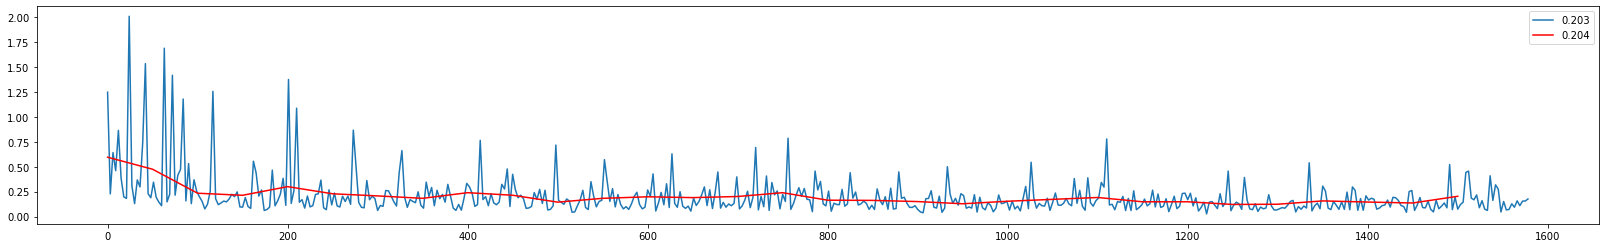

In [109]:
A = np.array(history['loss'])[1::20]
n = 3
b = 50
# N = (A.size // n) - n
mean_a = [A[i-n:i].mean() for i in range(n, A.size, n)]
mean_b = [A[i-b:i].mean() for i in range(b, A.size, b)]

plt.figure(figsize=(28,4))
plt.plot(np.arange(0, len(A)-n, n), mean_a, label=str(np.mean(mean_a))[:5])
plt.plot(np.arange(0, len(A)-b, b), mean_b, 'r', label=str(np.mean(mean_b))[:5])
# plt.yscale('log')
plt.legend()

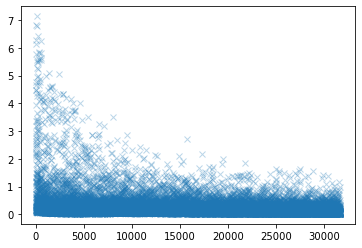

In [116]:
plt.plot(history['loss'], 'x', alpha=0.3)

In [92]:
threshold = 0.7

s = next(iter(validation_loader))
i, m = s['image'].to(device), s['mask'].to(device)

In [93]:
# model.eval()
model.eval()
out = model(i)

In [94]:
def dice_score(x, y, smooth = 1):
    union = (x * y).sum(2).sum(2).item()
    
    dice = (1 - ((2 * union + smooth) / 
                 (x.sum(2).sum(2).item() + y.sum(2).sum(2).item() + smooth)))
    return dice

original_mask = (m.clone().detach() > 0).type(torch.int)
new_mask = (out.clone().detach() > threshold).type(torch.int) 
dice = dice_score(original_mask, new_mask)
print('Dice score: ',dice)

Dice score:  0.2625157761884729


In [95]:
from torchvision.transforms import ToPILImage
untransform = ToPILImage()
i = untransform(i.squeeze(0).cpu())
out = untransform(out.squeeze(0).cpu())
m = untransform(m.squeeze(0).cpu())

/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


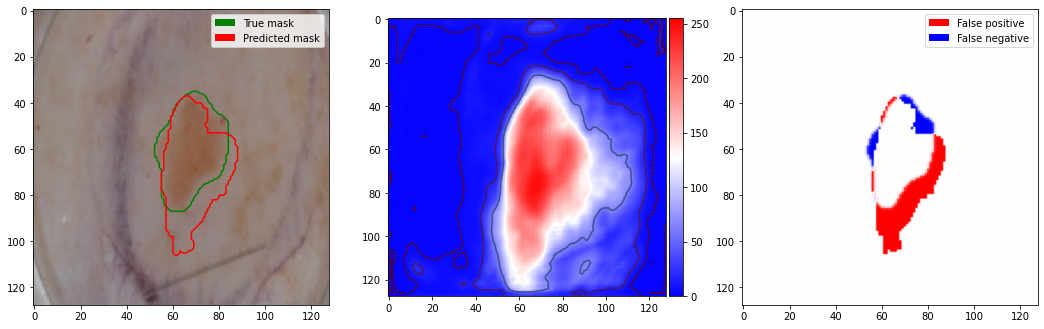

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

new_mask = np.array(np.array(out,dtype=float)/255 > threshold, dtype=float)

n = 3
fig, ax = plt.subplots(1,n, figsize=(18,6))

ax[0].imshow(i)
ax[0].contour(m, levels=[0.5], colors='green')
ax[0].contour(new_mask, levels=[1], colors='red')
proxy4img = [plt.Rectangle((0,0), 1,1, fc=c) for c in ['green', 'red']]
ax[0].legend(proxy4img, ['True mask', 'Predicted mask'])

diff = ax[1].imshow(out, 'bwr', vmax=255,vmin=0)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(diff, ax=ax[1], cax=cax)#, fraction=0.045)
ax[1].contour(np.array(out,dtype=float)/255, levels=np.logspace(-3,0,6))#, colors='black', alpha=0.5)

# red - false positive; blue - false negative
ax[2].imshow(new_mask - np.array(m,dtype=float)/255, 'bwr', vmax=1,vmin=-1)
proxy4mask = [plt.Rectangle((0,0), 1,1, fc=c) for c in ['red', 'blue']]
ax[2].legend(proxy4mask, ['False positive', 'False negative'])

# for j in range(n):
#     ax[j].axis('off')

plt.show()

In [429]:
# import scipy.ndimage as spim

# threshold = 0.7
# new_mask = np.array(out_mask > threshold, dtype=float)

# imer = spim.binary_erosion(new_mask)

# plt.imshow(i)
# c1 = plt.contour(new_mask, levels=[0.5], colors='green')
# c2 = plt.contour(m, levels=[1], colors='red')

# proxy = [plt.Rectangle((0,0), 1,1, fc=c) for c in ['green', 'red']]

# plt.legend(proxy, ['True mask', 'Predicted mask'])

In [24]:
# test the model

# original_mask = torch.tensor(m > 0, dtype=torch.int)
# new_mask = torch.tensor(m > threshold, dtype=torch.int)

def dice_score(x, y, smooth = 1):
    union = (x * y).sum(2).sum(2).item()
    
    dice = (1 - ((2 * union + smooth) / 
                 (x.sum(2).sum(2).item() + y.sum(2).sum(2).item() + smooth)))
    return dice

def test(model, test_loader, device, loss_fn, score_fn):
    scores = []
    losses = []
    
    with torch.no_grad():
        model.eval()
        
        for i, sample in enumerate(test_loader): 
            image, mask = sample['image'].to(device), sample['mask'].to(device)
            
            pred_mask = model(image)
            
            loss = loss_fn(pred_mask, mask)
            
            y = (mask.clone().detach() > 0).type(torch.int)
            yhat = (pred_mask.clone().detach() > threshold).type(torch.int)  
            score = score_fn(yhat, y)
            
            losses += [loss.item()]
            scores += [score]
            
    return np.array(scores), np.array(losses) 
    
scores, losses = test(model, test_loader, device, loss_fn, dice_score)

print('Score: {}, Loss: {}'.format(scores.mean(), losses.mean()))

Score: 0.6029304402664236, Loss: 0.47366094982572954


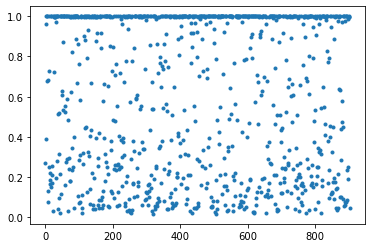

In [25]:
plt.plot(scores, '.')
# plt.bar(scores, np.arange(scores.size), width=0.005)